In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

class RNN(nn.Module):
        def __init__(self):
            super(RNN, self).__init__()
            self.rnn = nn.RNN(input_size=NUM, hidden_size=30, num_layers=2, batch_first=True)
            self.fc = nn.Linear(30, 1)
        def forward(self, x):
            x, _status = self.rnn(x)
            x = self.fc(x[:, -1])
            return x
        
def draw_graph(WINDOW):
    df = pd.read_csv("./data/02_시간별 제주 전력수요량.csv", encoding="UTF-8" )
    df["sum"] = df.sum( axis = 1, numeric_only=True)
    scaler = MinMaxScaler()
    scale_cols = ['1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시', '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시', '22시', '23시', '24시', 'sum']
    df_scaled = scaler.fit_transform(df[scale_cols])
    df = pd.DataFrame(df_scaled, columns=scale_cols)
    new_column_names = {"날짜": "Date", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9", 10: "10", 11: "11", 12: "12", 13: "13", 14: "14", 15: "15", 16: "16", 17: "17", 18: "18", 19: "19", 20: "20", 21: "21", 22: "22", 23: "23", 24: "24"}
    df.rename(columns=new_column_names, inplace=True)
    class DemandDataset(Dataset):
        def __init__(self, df):
            self.data = df
            self.x = self.data.iloc[:, -1].values
        def __len__(self):
            return len(self.data)-WINDOW
        def __getitem__(self, idx):
            return self.x[idx:idx+WINDOW], self.x[idx+WINDOW]
    dataset = DemandDataset(df)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
    
    model = RNN()
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
    def compute_r2_score(y_true, y_pred):
        return r2_score(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
    for epoch in range(300):
        for i, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(x.unsqueeze(1).float())
            loss = criterion(output.squeeze(), y.float())
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            y_true = y.float().unsqueeze(1)  
            y_pred = model(x.unsqueeze(1).float())  
            r2 = compute_r2_score(y_true, y_pred.squeeze())
            print(f"Epoch {epoch}: Loss: {loss}, R-squared: {r2}")
    
    data = list(df["sum"].values)
    for i in range(40000):
        x = data[0+i:i+WINDOW]
        output = model(torch.tensor(x).unsqueeze(0).unsqueeze(1).float())
        if i>=5479-WINDOW:
            data.append(output.squeeze().detach().numpy().item())
    plt.plot(data)
    plt.plot(df["sum"], label="실제")
    for i in range(0, len(data), 5479):
        plt.axvline(x=i, color="black", linestyle="--")
    return model

Epoch 0: Loss: 0.017182979732751846, R-squared: 0.3185719132823144
Epoch 10: Loss: 0.0057393815368413925, R-squared: 0.7139491722994851
Epoch 20: Loss: 0.00403240229934454, R-squared: 0.8266410688303514
Epoch 30: Loss: 0.005081516690552235, R-squared: 0.8313876508681837
Epoch 40: Loss: 0.006129447836428881, R-squared: 0.8473104757217838
Epoch 50: Loss: 0.004043385852128267, R-squared: 0.8968035595564442
Epoch 60: Loss: 0.002262930618599057, R-squared: 0.9325144607881669
Epoch 70: Loss: 0.005199176259338856, R-squared: 0.8464979307382156
Epoch 80: Loss: 0.0012945650378242135, R-squared: 0.9414942205809168
Epoch 90: Loss: 0.001538351527415216, R-squared: 0.9546310521156147
Epoch 100: Loss: 0.0021963438484817743, R-squared: 0.944359377565346
Epoch 110: Loss: 0.001482456922531128, R-squared: 0.9264479397363887
Epoch 120: Loss: 0.0036416666116565466, R-squared: 0.8631848148271772
Epoch 130: Loss: 0.002006694208830595, R-squared: 0.8936113426885415
Epoch 140: Loss: 0.0029779979959130287, R-s

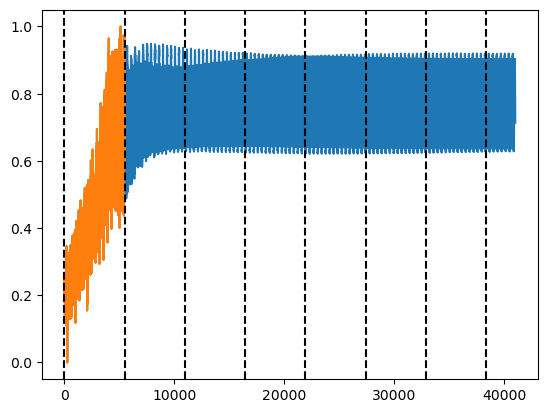

In [14]:
NUM=1000
torch.save(draw_graph(1000), "./model/model1000.pth")

Epoch 0: Loss: 0.022568637505173683, R-squared: 0.3044830008656534
Epoch 10: Loss: 0.0033994638361036777, R-squared: 0.7784109503528432
Epoch 20: Loss: 0.0026826385874301195, R-squared: 0.8956754090635316
Epoch 30: Loss: 0.0039661601185798645, R-squared: 0.8530544981272133
Epoch 40: Loss: 0.0023823496885597706, R-squared: 0.8926389823282714
Epoch 50: Loss: 0.004309937823563814, R-squared: 0.8529278898035317
Epoch 60: Loss: 0.0032996232621371746, R-squared: 0.9016185986668309
Epoch 70: Loss: 0.001976589672267437, R-squared: 0.9148414382843162
Epoch 80: Loss: 0.0038107847794890404, R-squared: 0.8492815065241894
Epoch 90: Loss: 0.0024322893004864454, R-squared: 0.9285113292043642
Epoch 100: Loss: 0.004551840014755726, R-squared: 0.8257974292882384
Epoch 110: Loss: 0.0015065970364958048, R-squared: 0.9133410454047368
Epoch 120: Loss: 0.002320530591532588, R-squared: 0.908757171205573
Epoch 130: Loss: 0.0022601629607379436, R-squared: 0.9091113930343899
Epoch 140: Loss: 0.002173792337998748

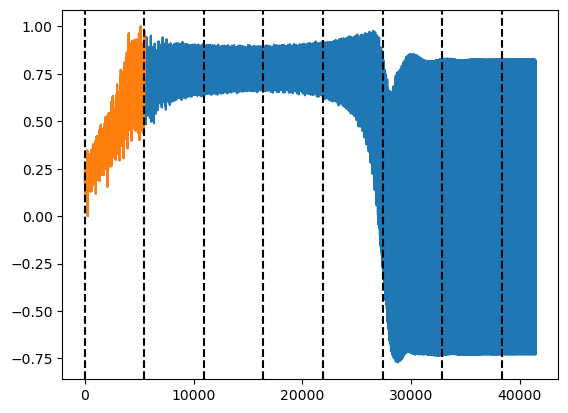

In [15]:
NUM=1500
torch.save(draw_graph(1500), "./model/model1500.pth")

Epoch 0: Loss: 0.02084241434931755, R-squared: -0.07289122623932576
Epoch 10: Loss: 0.005581132601946592, R-squared: 0.7373559229000062
Epoch 20: Loss: 0.004044544883072376, R-squared: 0.8250675071108269
Epoch 30: Loss: 0.003742565866559744, R-squared: 0.7200830456898224
Epoch 40: Loss: 0.003727554576471448, R-squared: 0.866643580151898
Epoch 50: Loss: 0.006384772714227438, R-squared: 0.7193248972091447
Epoch 60: Loss: 0.002743383636698127, R-squared: 0.8783213554126239
Epoch 70: Loss: 0.00418434664607048, R-squared: 0.8829856703667349
Epoch 80: Loss: 0.002628627000376582, R-squared: 0.7634683865212545
Epoch 90: Loss: 0.0036794713232666254, R-squared: 0.831180920616587
Epoch 100: Loss: 0.0021302218083292246, R-squared: 0.9015429304443484
Epoch 110: Loss: 0.00394006771966815, R-squared: 0.8109639439902674
Epoch 120: Loss: 0.0035596690140664577, R-squared: 0.8746609761576508
Epoch 130: Loss: 0.003586120903491974, R-squared: 0.8878099004979486
Epoch 140: Loss: 0.0014271860709413886, R-squ

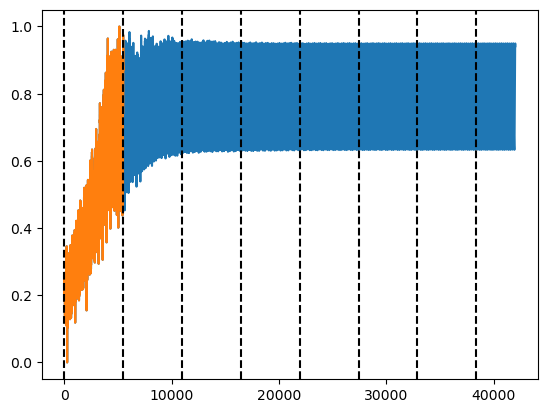

In [16]:
NUM=2000
torch.save(draw_graph(2000), "./model/model2000.pth")

Epoch 0: Loss: 0.2712897062301636, R-squared: -13.993103434104432
Epoch 10: Loss: 0.010258989408612251, R-squared: 0.4310818139909325
Epoch 20: Loss: 0.007113425061106682, R-squared: 0.6463815719507869
Epoch 30: Loss: 0.003318439470604062, R-squared: 0.7448509423738046
Epoch 40: Loss: 0.0024017326068133116, R-squared: 0.8502457031995725
Epoch 50: Loss: 0.0038049952127039433, R-squared: 0.7480185650981529
Epoch 60: Loss: 0.003701788140460849, R-squared: 0.7390624529817281
Epoch 70: Loss: 0.0040419260039925575, R-squared: 0.7257755444088918
Epoch 80: Loss: 0.004694144241511822, R-squared: 0.7571709036591341
Epoch 90: Loss: 0.0033542343880981207, R-squared: 0.7996479186248423
Epoch 100: Loss: 0.003545607440173626, R-squared: 0.7459455936230948
Epoch 110: Loss: 0.004838305525481701, R-squared: 0.7030238166641272
Epoch 120: Loss: 0.0017528075259178877, R-squared: 0.828857369586461
Epoch 130: Loss: 0.0056183296255767345, R-squared: 0.6604156081087931
Epoch 140: Loss: 0.0024828012101352215, R

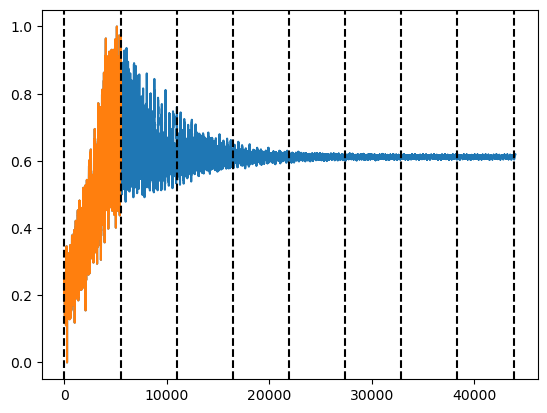

In [17]:
NUM=4000
torch.save(draw_graph(4000), "./model/model4000.pth")

Epoch 0: Loss: 0.3218272626399994, R-squared: -7.188337948464607
Epoch 10: Loss: 0.006902662105858326, R-squared: 0.7077909645725011
Epoch 20: Loss: 0.008484612219035625, R-squared: 0.7549483853943686
Epoch 30: Loss: 0.008961772546172142, R-squared: 0.7895100696381395
Epoch 40: Loss: 0.0027660257183015347, R-squared: 0.9327589701136525
Epoch 50: Loss: 0.0025409720838069916, R-squared: 0.906272988303078
Epoch 60: Loss: 0.0027937546838074923, R-squared: 0.9104417929831923
Epoch 70: Loss: 0.0020036085043102503, R-squared: 0.9216832235432852
Epoch 80: Loss: 0.00229308707639575, R-squared: 0.9400204301598762
Epoch 90: Loss: 0.0018050250364467502, R-squared: 0.9486093237940153
Epoch 100: Loss: 0.001269553555175662, R-squared: 0.9668498716833384
Epoch 110: Loss: 0.0035768283996731043, R-squared: 0.8922826728054055
Epoch 120: Loss: 0.0016399823362007737, R-squared: 0.8812985866450985
Epoch 130: Loss: 0.0014858589274808764, R-squared: 0.9545636784763203
Epoch 140: Loss: 0.001432480406947434, R-

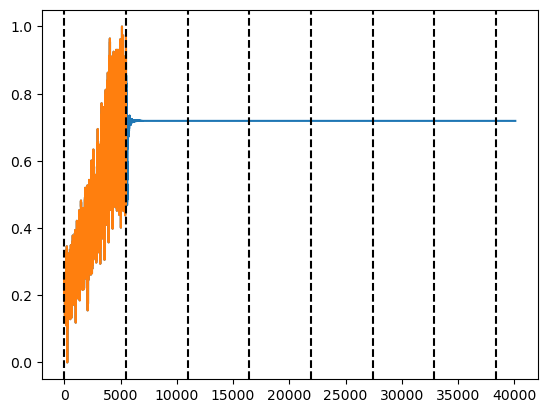

In [18]:
NUM=90
torch.save(draw_graph(90), "./model/model90.pth")

Epoch 0: Loss: 0.05571809038519859, R-squared: -1.4180601543963989
Epoch 10: Loss: 0.007357476279139519, R-squared: 0.6975608128761263
Epoch 20: Loss: 0.004214872606098652, R-squared: 0.8616102593130598
Epoch 30: Loss: 0.005670611280947924, R-squared: 0.8652187494369695
Epoch 40: Loss: 0.0022981902584433556, R-squared: 0.8707355120973876
Epoch 50: Loss: 0.0035849048290401697, R-squared: 0.9278490058398023
Epoch 60: Loss: 0.0020826621912419796, R-squared: 0.9579949024462465
Epoch 70: Loss: 0.0031821737065911293, R-squared: 0.9154830668675841
Epoch 80: Loss: 0.0016166612040251493, R-squared: 0.9599834733970889
Epoch 90: Loss: 0.001727931434288621, R-squared: 0.9257309496293039
Epoch 100: Loss: 0.0027794535271823406, R-squared: 0.9281717486688904
Epoch 110: Loss: 0.0015793058555573225, R-squared: 0.9461520649560871
Epoch 120: Loss: 0.0015008833725005388, R-squared: 0.9514537775360756
Epoch 130: Loss: 0.001570225926116109, R-squared: 0.9561837815691485
Epoch 140: Loss: 0.001968130469322204

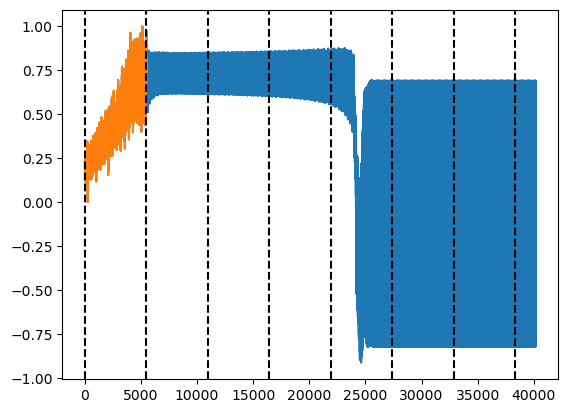

In [19]:
NUM=180
torch.save(draw_graph(180), "./model/model180.pth")

Epoch 0: Loss: 0.02148870751261711, R-squared: 0.1459070032835702
Epoch 10: Loss: 0.0062171537429094315, R-squared: 0.7840755708348617
Epoch 20: Loss: 0.003824972314760089, R-squared: 0.8954137108060967
Epoch 30: Loss: 0.0027197569143027067, R-squared: 0.9227828026960264
Epoch 40: Loss: 0.0033859815448522568, R-squared: 0.899899888926085
Epoch 50: Loss: 0.003223058534786105, R-squared: 0.8819853470177139
Epoch 60: Loss: 0.00278463470749557, R-squared: 0.9193143918981264
Epoch 70: Loss: 0.004082271829247475, R-squared: 0.8710296439923267
Epoch 80: Loss: 0.0010517558548599482, R-squared: 0.9780328222714939
Epoch 90: Loss: 0.0027888095937669277, R-squared: 0.9233006127732589
Epoch 100: Loss: 0.004021101631224155, R-squared: 0.9092389585479259
Epoch 110: Loss: 0.0014578666305169463, R-squared: 0.9258005791182212
Epoch 120: Loss: 0.0009267869172617793, R-squared: 0.9662709823976031
Epoch 130: Loss: 0.002224355936050415, R-squared: 0.9100019636931025
Epoch 140: Loss: 0.0025336947292089462, R

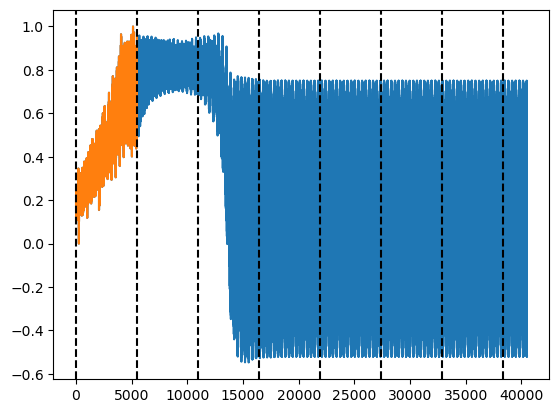

In [20]:
NUM=500
torch.save(draw_graph(500), "./model/model500.pth")

Epoch 0: Loss: 0.24251234531402588, R-squared: -7.21357113155978
Epoch 10: Loss: 0.015518536791205406, R-squared: 0.48080890227537054
Epoch 20: Loss: 0.009632051922380924, R-squared: 0.7548386539332687
Epoch 30: Loss: 0.0029693548567593098, R-squared: 0.858508753516114
Epoch 40: Loss: 0.004121137782931328, R-squared: 0.9105988340044289
Epoch 50: Loss: 0.0022321848664432764, R-squared: 0.9398043975770959
Epoch 60: Loss: 0.0034698082599788904, R-squared: 0.8983008168860254
Epoch 70: Loss: 0.0028299912810325623, R-squared: 0.9143197251317619
Epoch 80: Loss: 0.002981078578159213, R-squared: 0.903900664620717
Epoch 90: Loss: 0.003382544731721282, R-squared: 0.9033311512237132
Epoch 100: Loss: 0.0017314570723101497, R-squared: 0.9539998862158952
Epoch 110: Loss: 0.002133955480530858, R-squared: 0.9349175593572923
Epoch 120: Loss: 0.0019755088724195957, R-squared: 0.8929701196821059
Epoch 130: Loss: 0.0030489081982523203, R-squared: 0.8944793828672374
Epoch 140: Loss: 0.0016829583328217268, R

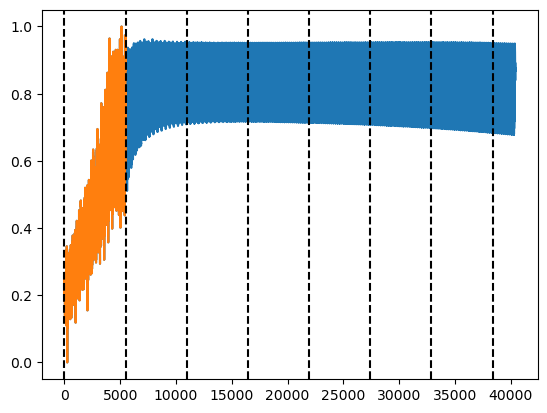

In [21]:
NUM=390
torch.save(draw_graph(390), "./model/model390.pth")

Epoch 0: Loss: 0.329341858625412, R-squared: -10.99131586323225
Epoch 10: Loss: 0.008551293052732944, R-squared: 0.7591605380016211
Epoch 20: Loss: 0.003327280515804887, R-squared: 0.8916243305072089
Epoch 30: Loss: 0.006314593367278576, R-squared: 0.7142390104059319
Epoch 40: Loss: 0.00582939013838768, R-squared: 0.8552319988410655
Epoch 50: Loss: 0.005678299814462662, R-squared: 0.8658334638475238
Epoch 60: Loss: 0.0038382448256015778, R-squared: 0.9120828121395235
Epoch 70: Loss: 0.002314262092113495, R-squared: 0.9444277619724973
Epoch 80: Loss: 0.0016807898646220565, R-squared: 0.9477893078195612
Epoch 90: Loss: 0.0009602515492588282, R-squared: 0.9562092085271301
Epoch 100: Loss: 0.0024537886492908, R-squared: 0.9302273890145769
Epoch 110: Loss: 0.0013286543544381857, R-squared: 0.9567243579406135
Epoch 120: Loss: 0.0010137303033843637, R-squared: 0.9670367204269248
Epoch 130: Loss: 0.0006906564231030643, R-squared: 0.9816319826756742
Epoch 140: Loss: 0.00247806659899652, R-squar

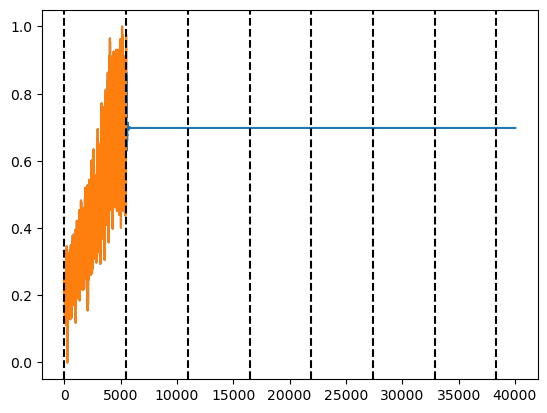

In [22]:
NUM=30
torch.save(draw_graph(30), "./model/model30.pth")